**PART 1**

First we import rasterio, a library for reading and manipulating raster datasets: information datasets such as GEOtif files, which is what our GHSL Population dataset is. Rasterio doesn't usually come with most basic python packages so it is necessary to install it manually.

In [ ]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 39.5 MB/s eta 0:00:00


Then we import all packages we will be using.

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import scipy.ndimage
import numpy as np
import random
import pyproj
import folium
import ast



**PART 2**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R3_C18.tif to GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R3_C18.tif


First we access the dataset, and provide the meta data for it. Note that this is only one small subtile of the overall global dataset.

In [ ]:


dataset2 = rasterio.open("GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R3_C18.tif")

data = dataset2.read(1)

Various aspects of the array.

In [ ]:
dataset2.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': -200.0,
 'width': 10000,
 'height': 10000,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(100.0, 0.0, -1041000.0,
        0.0, -100.0, 7000000.0)}

In [ ]:
dataShape = dataset2.shape
dataShape

(10000, 10000)

Next we visualise the array using matplotlib to generate a heatmap of the population distribution of the area. Brighter colours indicate higher population density.

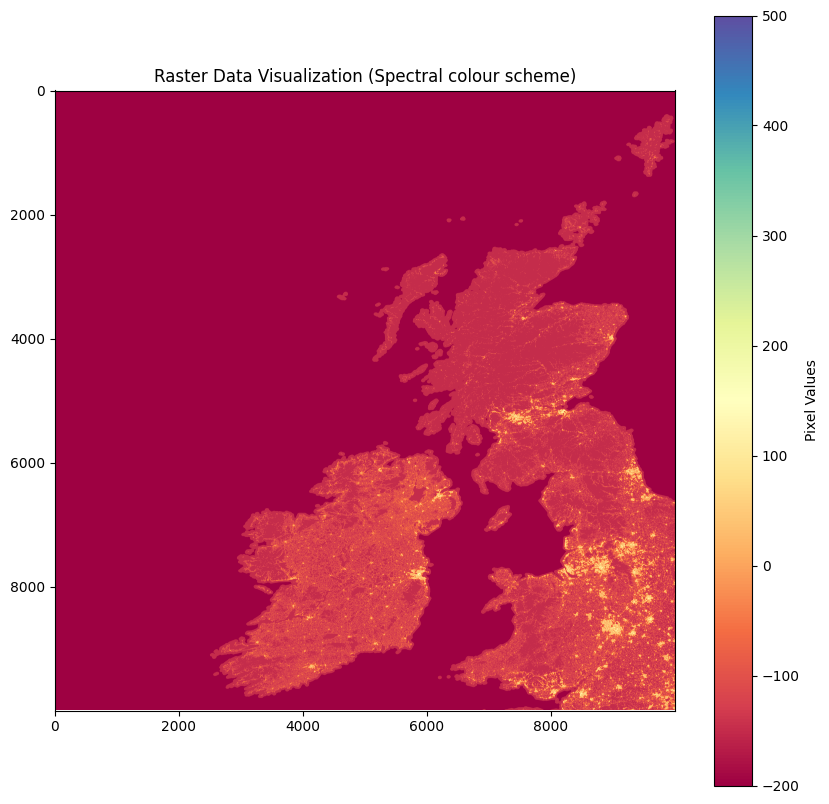

In [ ]:


dataset2 = rasterio.open("GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0_R3_C18.tif")
data =dataset2.read(1)

colourschemes = ['PuOr', 'Spectral']
cmap = random.choice(colourschemes)

vmin=-200
vmax=500

#Here I altered some of the values in order to get a higher contrast between colours, but nothing important was changed and the image is still accurate.
data[data == 0] = -150


plt.figure(figsize=(10, 10))
plt.imshow(data, cmap=cmap,clim=(vmin, vmax))
plt.colorbar(label='Pixel Values')
plt.title(f'Raster Data Visualization ({cmap} colour scheme)')
plt.show()

data[data == -150] = 0


dataset2.close()



Next I create a quick function that recreates the heatmap of the dataset and overlays a set of points, this will be useful for checking the validity of my candidate points for most isolated points.

In [ ]:
def visualise(points,data):

    cmap = 'Spectral'
    data[data == 0] = -150

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the original data
    image = ax.imshow(data, cmap=cmap, vmin=-200, vmax=500)

    if isinstance(points,list):
      for i in points:
          ax.plot(i[0], i[1],  marker ='x', color = 'green', markersize=5, mew=2)
    else:
      ax.plot(points[1], points[0],  marker ='x', color = 'green', markersize=5, mew=2)



    # Customize colorbar
    cbar = plt.colorbar(image, label='Pixel Values')


    # Set the title
    plt.title(f'Raster Data Visualization ({cmap} colour scheme)')

    # Show the plot
    plt.show()

    data[data == -150] = 0

After testing multiple methods, I ultimatey decided to use the distance transform function provided by scipy as a method for calculating the most distance point from any points of human population.

In [ ]:
"""

This section calculates the maximum distance from non-zero elements in a given data array.
It does so by creating a binary mask where non-zero elements are represented as 0 and zero elements as 1.
Then, the distance transform is applied to this mask, and the maximum distance value is extracted along
with the indices of points where this maximum distance occurs

"""

zero_pop_mask  = np.where(data != 0,0,1)

distance_transform = scipy.ndimage.distance_transform_edt(zero_pop_mask)



max_distance = np.max(distance_transform)
max_distance_indices = np.argwhere(distance_transform == max_distance)



This next section rearranges the indices into a way that can be read later on.

In [ ]:
print(f'Maximum distance from point to humans is {round(max_distance*100,2)} metres')

print(f'Location of point/points of maximum distance is {max_distance_indices}')
correct_layout = []

for i in max_distance_indices:


  i = (i[1],i[0])
  correct_layout.append(i)

#print(correct_layout)



Maximum distance from point to humans is 6963.48 metres
Location of point/points of maximum distance is [[2812 6160]
 [2814 6157]]


As we can see below, the result for this array is indeed the most isolated region in Northern Britain. Confident that we can work with this program, we most forward with its implementation into a larger dataset.

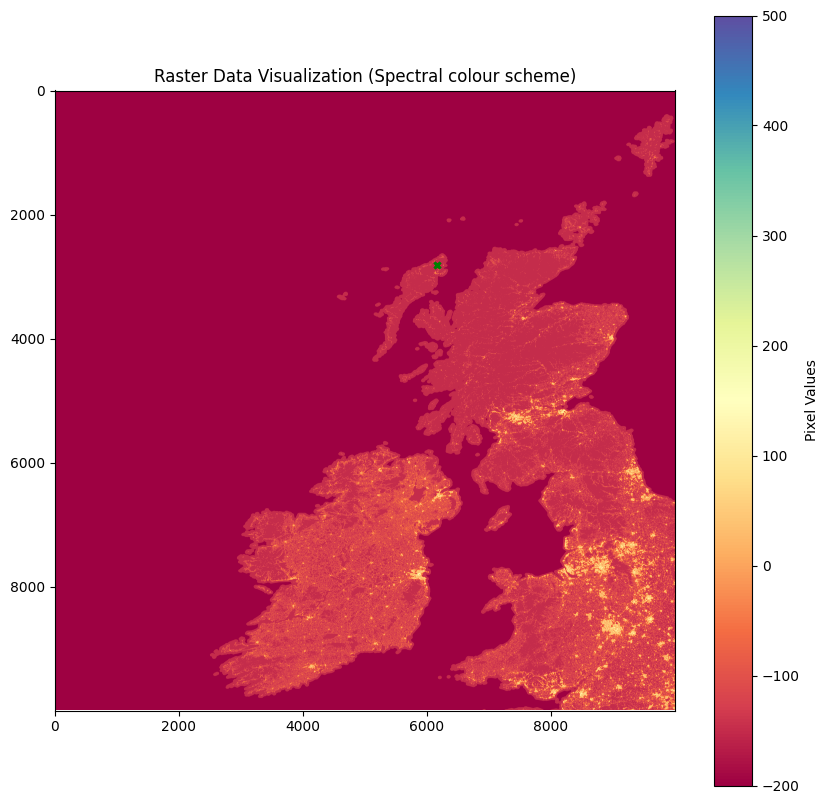

In [ ]:
visualise(correct_layout,data)

-



-

**------- END OF PART 1 ----------**

-

-

**PART 2**

Now that we have the the lists of different overlapping subtiles covering the entire global dataset, we need to read it and filter the data to extract a single candidate for position of most lonely place.

First we will define all the functions we will be using.

In [ ]:

"""
Cleanup and Parse Text File into List of Lists.

This function reads a text file containing lines of text representing lists,
each in string format. It processes the content of the file, and attempts to evaluate each line as a list using the `ast.literal_eval` function.
Valid list entries are extracted and stored in a list. If a line contains syntax errors
and cannot be evaluated as a list, a SyntaxError message is printed.

Parameters:
    text_file (str): Path to the text file to be processed.

Returns:
    list: A list of lists containing information parsed from the input text file.

"""



def cleanup(text_file):

    listy = []

    with open(text_file, 'r') as file:
        content = file.readlines()

    for line in content[1:]:


        try:
            info = ast.literal_eval(line.rstrip())
            listy.append(info)
        except SyntaxError as e:
            print("SyntaxError:", e)

    return listy


In [ ]:
"""
Filter List of Candidates Based on Distance Threshold.

This function takes a list of candidates, each represented as a list-like object, and filters
them based on a distance threshold. The distance threshold can be specified as a ratio of the maximum
distance in the list or as an absolute value.

Parameters:
    listy (list): A list of candidate items, each containing at least 4 numerical values.
    threshold (float, optional): The distance threshold for filtering candidates. If set to 0 (default),
                                 only one candidate with the maximum distance is retained. Otherwise, candidates
                                 with distances greater than `threshold` (float between 0-1) times the maximum distance are kept.

Returns:
    list: A list of filtered candidate items that satisfy the specified distance threshold.
"""


def filter(listy, threshold = 0):

  max_distance = 0
  finalcands= []

  for i in listy:
    if i[3]>max_distance:

      max_distance = i[3]

  if threshold == 0:
    for i in listy:
      if i[3] == max_distance:
        finalcands.append(i)

  else:
      for i in listy:
        if i[3] > max_distance*threshold:
          finalcands.append(i)




  print(f'Amount of candidates: {len(finalcands)}')
  return finalcands



In [ ]:
"""

Create Folium Map with Markers and Popup Information.

This function generates a Folium map and adds markers to it based on the provided list of data points.
Each data point in the list is expected to have specific values representing geographical information,
distances, and population statistics. A formatted string containing these values is used as a popup for
each marker.

Parameters:
    listy (list): A list of data points, where each data point is a list-like object containing
                  geographical and statistical values.

Returns:
    folium.Map: A Folium map containing markers at the specified data point locations, each with a popup.

    """


def makemap(listy):

    m = folium.Map(location=[0, 0], zoom_start=1.5, tiles='OpenStreetMap')


    for i in listy:



        latitude, longitude = i[0]
        molleweide_x, molleweide_y = i[1]
        overall_row,overall_col = i[2]
        distance_nearest_person = i[3]
        overall_population = i[4]
        population_smaller_tile = i[5]

        formatted_string = (
          f"<div style='width: 300px;'>"

          f"1: Latitude and Longitude: {round(i[0][0], 2)},{round(i[0][1], 2)}<br>"
          f"2: Molleweide Projection: X: {round(molleweide_x, 2)}, Y: {round(molleweide_y)}<br>"
          f"3: Overall Array Loc: Row: {round(overall_row, 2)}, Column: {round(overall_col)}<br>"
          f"4: Distance from nearest person: {round(distance_nearest_person*100, 2)} meters<br>"
          f"5: Overall population in that tile: {round(overall_population)}<br>"
          f"6: Population in smaller tile: {round(population_smaller_tile)}"
          f"</div>"
        )

        folium.Marker(location=i[0], icon = folium.Icon(icon='user'),popup=formatted_string).add_to(m)
    return m




First, we convert the text files containing our raw data from the main program to a series of lists, then make sure that we have all 20.

In [ ]:
list_of_lists = []
for i in range(0,10000,500):


  list_of_lists.append(cleanup(str(i)+","+str(i)+".txt"))

In [ ]:
print(len(list_of_lists))

20


Due to a mistake in the main scan, I ran a couple of the scans twice by accident, and so some of the information was entered twice, the following is just me deleting unnecessary duplicates.

In [ ]:
duplicate = list_of_lists[6]
print(len(duplicate))


templist= []
for i in duplicate:
  if i not in templist:

    templist.append(i)
print(len(templist))

list_of_lists[6] = templist

882
342


In [ ]:
duplicate = list_of_lists[11]
print(len(duplicate))


templist= []
for i in duplicate:
  if i not in templist:

    templist.append(i)
print(len(templist))

list_of_lists[11] = templist

446
330


Check to make sure all lists are expected length, roughly one half of the global dataset was ocean and so wasn't scanned. Small variations are explained by the changed starting dimensions of each scan.

In [ ]:
for i in list_of_lists:
  print(len(i))

332
333
330
326
325
323
342
324
323
319
321
330
325
324
322
318
314
313
316
316


Add the information into one large list, resulting in roughly 6500 candidate points.

In [ ]:
total_list = []
for i in list_of_lists:
  for p in i:
    total_list.append(p)
print(len(total_list))

6476


Our first test is to see how many candidate points were logged as most isolated many times, so we define a quick function to see which pointd were maximally specified.

In [ ]:
"""
Count Occurrences of Candidate Data Points in the Total List.

This function calculates the occurrences of candidate data points in a total list of data points.
It counts the number of occurrences for each unique data point and returns a dictionary with data points
as keys and their respective counts as values.

Parameters:
    cand (list): A list of candidate data points, where each data point is a list-like object.
    alllist (list, optional): The total list of data points to search within. Default is `total_list`.

Returns:
    dict: A dictionary where keys are candidate data points and values are the count of occurrences
          of each candidate data point in the total list.

"""

def howmany(cand, alllist = total_list):

  dic ={}
  for i in total_list:
    l= total_list.count(i)

    dic[i[0]] = l

  return dic







{(-8.567793571112851, -172.48623055967317): 1, (-16.85304362373248, -179.93523423482213): 1, (27.782811633701964, -175.83368931708233): 2, (4.7046069391209535, -160.38755327252446): 1, (-13.596238618524717, -172.4374611818673): 1, (-19.736412712367454, -175.07492032181852): 1, (-29.268852443400775, -177.90822631311448): 7, (25.00106330228775, -167.99799762865862): 3, (19.388923995546943, -155.58879216714118): 1, (1.832383377488014, -157.40064871585227): 7, (-4.013150652793299, -154.9283701723632): 10, (-10.440301874144843, -160.98464119877494): 7, (-21.922479399029704, -157.90871816154154): 4, (19.64289359162217, -155.65109712463934): 1, (-14.424226859250894, -144.9349348695328): 1, (-17.68608371239289, -149.49817025262843): 1, (-44.05075437272842, -176.49606435072386): 15, (51.83683798256647, -177.9895314787564): 1, (51.21347062420298, -179.14754459327963): 1, (-7.9782700450422785, -140.6687038917026): 1, (-9.778007582772352, -139.10895771660597): 1, (-21.872545699722092, -138.9757724

Using this function I discovered that some points were logged 20 times.

I then created a list of point that were logged 20 times, thinking that these were the most reliable points from scanning multiple times and so had the best chance of being the true most lonely points.

In [ ]:
multipleEntries=[]
max = 0
for i in total_list:
  if total_list.count(i)==max:
    multipleEntries.append(i)

  if total_list.count(i)>max:
    max = total_list.count(i)


#for i in multipleEntries[1:]:

  #print(total_list.count(i))

multipleEntries= multipleEntries[1:]

print(len(multipleEntries))

39


I then created a map visualisation to show where these points existed on the planet, with information about their population values and distance to nearest humans available upon clicking the icons.

In [ ]:
makemap(multipleEntries)

After that I removed all multiple entries from the overall list of candidates and saw what else I could find from the data.

In [ ]:
unique_list = []
for i in total_list:
  if i not in unique_list:
    unique_list.append(i)

print(len(unique_list))





5868


The filter function takes an argument 'threshold' that is either 0, its default, or a float between 0-1 which will return a set of points with minimum distance to the nearest human settlement values. The below figure shows candidates in the top 30% of distance, but feel free to change the threshold value and look at the changing candidates yourself.

In [ ]:
makemap(filter(unique_list,0.7))

Amount of candidates: 13


Next I changed the list to only include candidate points that were surrounded by an array of 2000X2000 empty space i.e. roughly 4000km2 of no humans.

In [ ]:
filtered_list_bysmalltile = [i for i in unique_list if i[5] == 0]
print(len(filtered_list_bysmalltile))






1159


The filter function takes an argument 'threshold' that is either 0, its default, or a float between 0-1 which will return a set of points with minimum distance to the nearest human settlement values. The below figure shows candidates in the top 30% of distance, but feel free to change the threshold value and look at the changing candidates yourself.

In [ ]:
makemap(filter(filtered_list_bysmalltile,0.7))

Amount of candidates: 13


-

-

-

-

Finally I created a list that only included candidate points that existed in overall empty tiles. Due to the bias of empty tiles affecting the ability of the program to focus on points distant from human population, I decided to go back to the small tile defined set.

In [ ]:
filtered_list_bybigtile = [i for i in unique_list if i[4] == 0]
print(len(filtered_list_bybigtile))




168


The filter function takes an argument 'threshold' that is either 0, its default, or a float between 0-1 which will return a set of points with minimum distance to the nearest human settlement values. The below figure shows candidates in the top 30% of distance, but feel free to change the threshold value and look at the changing candidates yourself.

In [ ]:
makemap(filter(filtered_list_bybigtile,0.7))

Amount of candidates: 4


Finally I decided to use the absolute filter on the small tile defined set, to come over with my definitive answer to the question of "The Most Lonely place on Earth".

In [ ]:
makemap(filter(filtered_list_bysmalltile))

Amount of candidates: 1
